## Toy MC plots for the paper
----------
Generates those plots that are used in the final version of the paper. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ultrasurfaces_paper_plotstyle.mplstyle")

from toy_mc import generator
from importlib import reload

In [2]:
from utils import generate_histogram_at_response
from utils import chi_square, chi_square_at_response

In [3]:
delta_msq_31 = 2.515e-3
sinsq_theta_23 = 0.565
# convert this to sin**2(2 \theta)
theta_23 = np.arcsin(np.sqrt(sinsq_theta_23))
sinsq_2theta_23 = np.sin(2 * theta_23)**2
default_pars = generator.OscPars(delta_msq_31, sinsq_2theta_23)

default_response = generator.Response(1., 0.08)

bin_edges = np.logspace(1., 2., 26)

In [4]:
gen = generator.Generator(int(1e5), default_response, default_pars)
h0 = gen.get_histogram(bin_edges)
h0_true = gen.get_histogram(bin_edges, variable="true_energy")

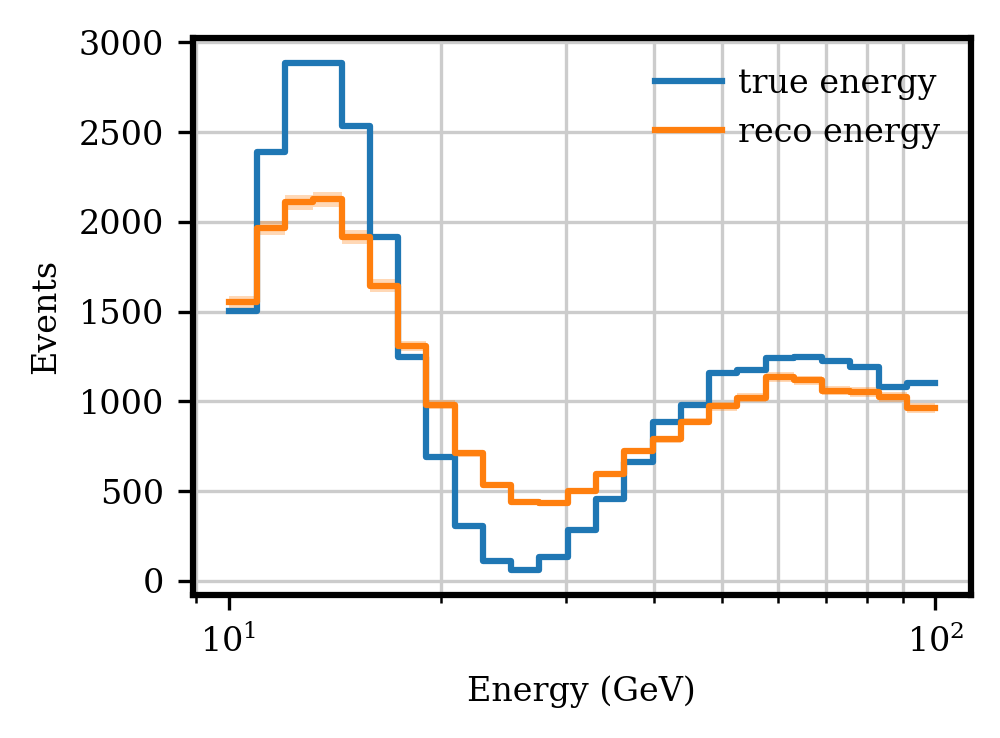

In [5]:
from toy_mc.histogram import plot_histogram

fig, ax = plt.subplots()
plot_histogram(h0_true, ax=ax, show_errorband=False, label="true energy")
plot_histogram(h0, ax=ax, label="reco energy")
# plt.minorticks_on()
plt.semilogx()
plt.legend()
plt.grid(which="both", axis="x")
plt.xlabel("Energy (GeV)")
plt.ylabel("Events")
plt.tight_layout()
plt.savefig("plot_output/toy_mc_histogram_true_reco.pdf")
plt.show()

In [6]:
# Generate several sets at different values of mu
reload(generator)
gen_nominal = generator.Generator(
    int(1e5), default_response, default_pars, name="nominal", rng_seed=0
)
# It looks like there is a breakdown point where, if the response is *too* different,
# the whole thing doesn't work anymore.
gen_sys_1 = generator.Generator(
    int(1.05 * 1e5),
    generator.Response(1.05 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_01",
    rng_seed=0
)
gen_sys_2 = generator.Generator(
    int(0.95 * 1e5),
    generator.Response(0.95 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_02",
    rng_seed=0
)
gen_sys_3 = generator.Generator(
    int(0.975 * 1e5),
    generator.Response(0.975 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_03",
    rng_seed=0
)
gen_sys_4 = generator.Generator(
    int(1.025 * 1e5),
    generator.Response(1.025 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_04",
    rng_seed=0
)

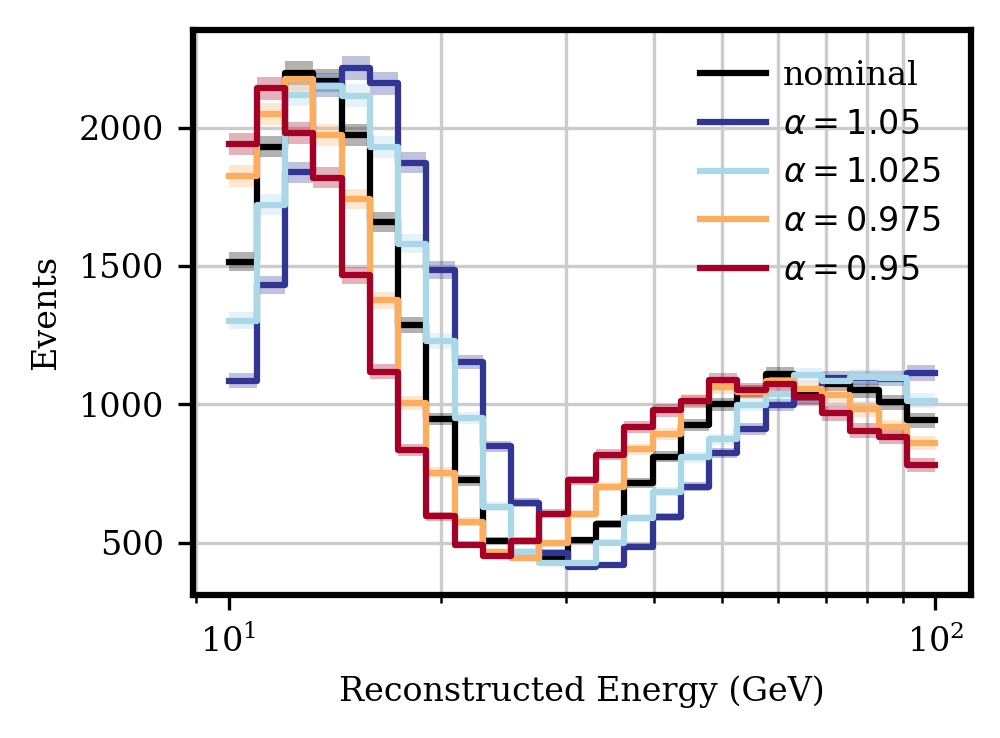

In [7]:
from toy_mc.histogram import plot_histogram

fig, ax = plt.subplots()
# write alpha instead of mu in the legend because we write that in the paper
plot_histogram(gen_nominal.get_histogram(bin_edges), ax=ax, label="nominal", color="k")
# color each histogram with a colormap according to its alpha value
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("RdYlBu")

plot_histogram(gen_sys_1.get_histogram(bin_edges), ax=ax, label=r"$\alpha=1.05$", color=cmap(1.0))
plot_histogram(gen_sys_4.get_histogram(bin_edges), ax=ax, label=r"$\alpha=1.025$", color=cmap(0.7))
plot_histogram(gen_sys_3.get_histogram(bin_edges), ax=ax, label=r"$\alpha=0.975$", color=cmap(0.3))
plot_histogram(gen_sys_2.get_histogram(bin_edges), ax=ax, label=r"$\alpha=0.95$", color=cmap(0.0))
plt.semilogx()
plt.legend()
plt.grid(which="both", axis="x")
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Events")
plt.tight_layout()
plt.savefig("plot_output/toy_mc_histogram_systematics.pdf")
plt.show()

### Apply KNN
Calculate class posterior probabilities using the (skew-corrected) KNN classifier

In [8]:
from surfaces import calculate_probs

df_with_probs = calculate_probs.calculate_probs_sklearn(
    gen_nominal,
    [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=200,
    jobs=4
)

Starting KNN evaluation...


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


In [9]:
df_with_probs

,true_energy,true_cos(zen),weights_pre_detector,reco_energy,weights,set,prob_nominal,prob_sys_01,prob_sys_02,prob_sys_03,prob_sys_04
0,23.060308,-1.0,0.052845,15.709762,0.052845,nominal,0.185853,0.038272,0.387166,0.277774,0.110935
1,17.137504,-1.0,0.524539,18.466420,0.524539,nominal,0.217790,0.243206,0.124540,0.175481,0.238983
2,41.707228,-1.0,0.326591,40.956423,0.326591,nominal,0.196734,0.178376,0.180790,0.212485,0.231615
3,22.513865,-1.0,0.070286,25.808697,0.070286,nominal,0.233787,0.252505,0.113376,0.179428,0.220905
4,10.768750,-1.0,0.654905,16.796014,0.654905,nominal,0.123933,0.532366,0.018506,0.051398,0.273797
...,...,...,...,...,...,...,...,...,...,...,...
99995,6.944873,-1.0,0.830246,7.473007,0.830246,nominal,0.229250,0.255631,0.126142,0.171193,0.217785
99996,1.388665,-1.0,0.299039,1.416954,0.299039,nominal,0.198088,0.267047,0.132038,0.167365,0.235462
99997,19.946151,-1.0,0.216703,16.917959,0.216703,nominal,0.200065,0.121217,0.283623,0.228830,0.166264
99998,5.646440,-1.0,0.379824,5.509054,0.379824,nominal,0.223920,0.163175,0.189542,0.218924,0.204439


### Calculate gradients
Calculate event-wise gradients by minimizing the log-likelihood.

In [10]:
from surfaces import calculate_grads

# get gradient names for systematic "mu"
grad_names = calculate_grads.make_gradient_names(["mu"], 2)
print(grad_names)
# make delta_p matrix for the systematic "mu" 
# (i.e. the detector response)
delta_p = calculate_grads.make_delta_p_from_grad_names(
    grad_names, [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4], gen_nominal
)
delta_p

['grad__mu', 'grad__mu__mu']


array([[ 0.      ,  0.05    , -0.05    , -0.025   ,  0.025   ],
       [ 0.      ,  0.0025  ,  0.0025  ,  0.000625,  0.000625]])

In [11]:
# Calculate the gradients
df_with_grads = calculate_grads.fit_gradients(
    df_with_probs, 
    prob_columns=["prob_nominal", "prob_sys_01", "prob_sys_02", "prob_sys_03", "prob_sys_04"], 
    delta_p=delta_p, 
    grad_names=grad_names
)

100%|██████████| 100000/100000 [00:20<00:00, 4808.33it/s]


In [12]:
df_with_grads

,true_energy,true_cos(zen),weights_pre_detector,reco_energy,weights,set,prob_nominal,prob_sys_01,prob_sys_02,prob_sys_03,prob_sys_04,grad__mu,grad__mu__mu
0,23.060308,-1.0,0.052845,15.709762,0.052845,nominal,0.185853,0.038272,0.387166,0.277774,0.110935,-21.521940,-142.809798
1,17.137504,-1.0,0.524539,18.466420,0.524539,nominal,0.217790,0.243206,0.124540,0.175481,0.238983,6.570737,-87.477246
2,41.707228,-1.0,0.326591,40.956423,0.326591,nominal,0.196734,0.178376,0.180790,0.212485,0.231615,0.304003,-68.384759
3,22.513865,-1.0,0.070286,25.808697,0.070286,nominal,0.233787,0.252505,0.113376,0.179428,0.220905,7.097078,-103.648260
4,10.768750,-1.0,0.654905,16.796014,0.654905,nominal,0.123933,0.532366,0.018506,0.051398,0.273797,33.572415,-91.446282
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,6.944873,-1.0,0.830246,7.473007,0.830246,nominal,0.229250,0.255631,0.126142,0.171193,0.217785,6.569121,-69.714193
99996,1.388665,-1.0,0.299039,1.416954,0.299039,nominal,0.198088,0.267047,0.132038,0.167365,0.235462,6.998093,-24.549113
99997,19.946151,-1.0,0.216703,16.917959,0.216703,nominal,0.200065,0.121217,0.283623,0.228830,0.166264,-8.041316,-23.113581
99998,5.646440,-1.0,0.379824,5.509054,0.379824,nominal,0.223920,0.163175,0.189542,0.218924,0.204439,-1.466821,-97.412337


-79.76372274708488 32.80056501587478


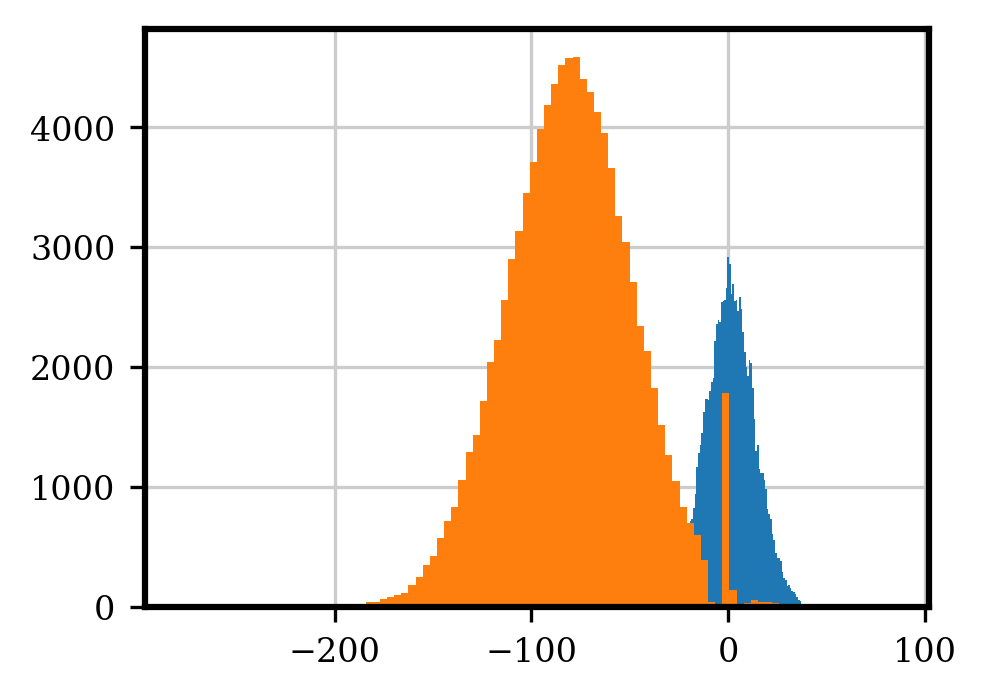

In [13]:
plt.hist(df_with_grads["grad__mu"], bins=100)
plt.hist(df_with_grads["grad__mu__mu"], bins=100)
# print mean and standard deviation of second order gradient
print(np.mean(df_with_grads["grad__mu__mu"]), np.std(df_with_grads["grad__mu__mu"]))
plt.show()

In [14]:
df_with_grads[df_with_grads["grad__mu__mu"] >= 0.0]

,true_energy,true_cos(zen),weights_pre_detector,reco_energy,weights,set,prob_nominal,prob_sys_01,prob_sys_02,prob_sys_03,prob_sys_04,grad__mu,grad__mu__mu
46,106.908034,-1.0,0.864523,125.319937,0.864523,nominal,0.188626,0.260295,0.143975,0.173221,0.233883,5.920508,0.018848
85,41.229280,-1.0,0.316317,48.941664,0.316317,nominal,0.214772,0.288487,0.136020,0.145868,0.214854,7.591016,0.061400
153,11.083802,-1.0,0.751489,6.631067,0.751489,nominal,0.120547,0.021349,0.555017,0.233069,0.070018,-29.585910,23.405853
250,25.174161,-1.0,0.018832,22.320579,0.018832,nominal,0.222945,0.162874,0.251949,0.204988,0.157243,-4.542806,0.021500
253,6.905308,-1.0,0.854432,7.694013,0.854432,nominal,0.226165,0.317804,0.115588,0.133357,0.207086,9.809532,0.064852
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99449,0.753754,-1.0,0.743609,0.738639,0.743609,nominal,0.197148,0.212962,0.187294,0.194922,0.207675,1.282123,0.003057
99625,32.214867,-1.0,0.107620,24.496212,0.107620,nominal,0.190758,0.114357,0.309627,0.249406,0.135851,-10.364065,0.056895
99896,41.143787,-1.0,0.314464,47.162818,0.314464,nominal,0.232080,0.267947,0.154305,0.132273,0.213396,6.231435,0.033036
99943,9.044797,-1.0,0.062475,10.752282,0.062475,nominal,0.175778,0.315296,0.109102,0.150411,0.249414,10.522325,0.080592


In [15]:
def plot_one_event(index, ax):
    probs = df_with_grads.loc[
        index,
        ["prob_nominal", "prob_sys_01", "prob_sys_02", "prob_sys_03", "prob_sys_04"],
    ].to_numpy()
    grads = df_with_grads.loc[index, grad_names].to_numpy(dtype=float)

    print(grads)

    delta_mu_plot = np.linspace(0.94, 1.06, 100) - 1
    predicted_probs = np.exp(grads[0] * delta_mu_plot + grads[1] * delta_mu_plot**2)

    mu_sets = [
        gen.detector_response.mu
        for gen in [gen_nominal, gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4]
    ]
    mu_sets = np.array(mu_sets)
    # Normalize the predicted probabilities over the sets
    pred_probs_sets = np.exp(np.dot(grads, np.asarray(delta_p)))
    set_normalization = np.sum(pred_probs_sets)

    pred_probs_sets = pred_probs_sets / set_normalization
    # We plot the interpolated probabilities with the same normalization
    # (in practice, we are only interested in ratios between sets and 
    # therefore the normalization is not important)
    predicted_probs = predicted_probs / set_normalization

    ax.plot(mu_sets, probs, "o", label="KNN probabilities")
    ax.plot(delta_mu_plot + 1, predicted_probs, label="best fit")


[ -11.07421369 -103.45094644]


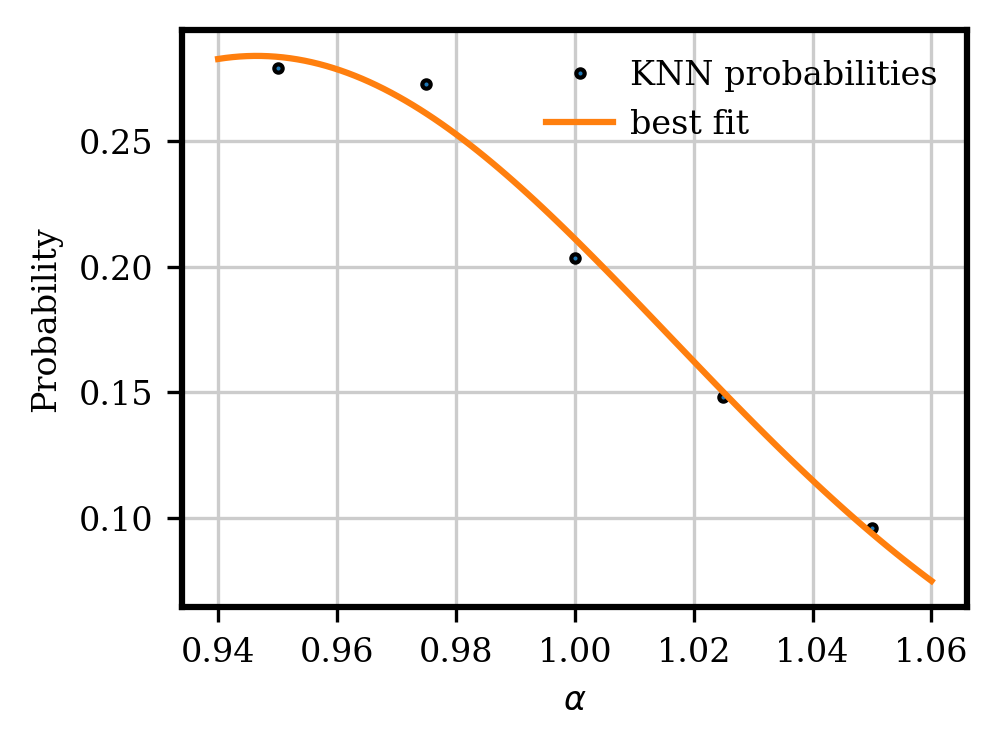

In [16]:
fig, ax = plt.subplots()
plot_one_event(42, ax)
plt.legend()
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Probability")
plt.show()

In [17]:
import matplotlib

def plot_gradient_map(df, grad_name, true_e_binning, reco_e_binning, symmetric=True, ax=None):
    """
    Plot the amplitude of a gradient as a function of the true and reconstructed energy.
    Shows a colormap in the given binning where the color in each bin corresponds to the
    average value of the gradient in that bin.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with the gradient values
    grad_name : str
        Name of the gradient to plot
    true_e_binning : array-like
        Binning of the true energy axis
    reco_e_binning : array-like
        Binning of the reconstructed energy axis
    symmetric : bool, optional
        If True, the colorbar will be symmetric around zero
    ax : matplotlib.axes.Axes, optional
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Calculate the average gradient in each bin
    grad_map, _, _ = np.histogram2d(
        df["true_energy"],
        df["reco_energy"],
        bins=[true_e_binning, reco_e_binning],
        weights=df[grad_name],
    )
    n_entries, _, _ = np.histogram2d(
        df["true_energy"], df["reco_energy"], bins=[true_e_binning, reco_e_binning]
    )
    with np.errstate(divide="ignore", invalid="ignore"):
        grad_map = grad_map / n_entries

    # Plot the gradient map
    if symmetric:
        vmax = np.nanmax(np.abs(grad_map))
        vmin = -vmax
    else:
        vmin = np.nanmin(grad_map)
        vmax = np.nanmax(grad_map)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    im = ax.pcolormesh(
        true_e_binning,
        reco_e_binning,
        grad_map.T,
        cmap="coolwarm",
        # cmap="RdYlBu",
        shading="flat",
        norm=norm,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("True Energy (GeV)")
    ax.set_ylabel("Reconstructed Energy (GeV)")
    return im

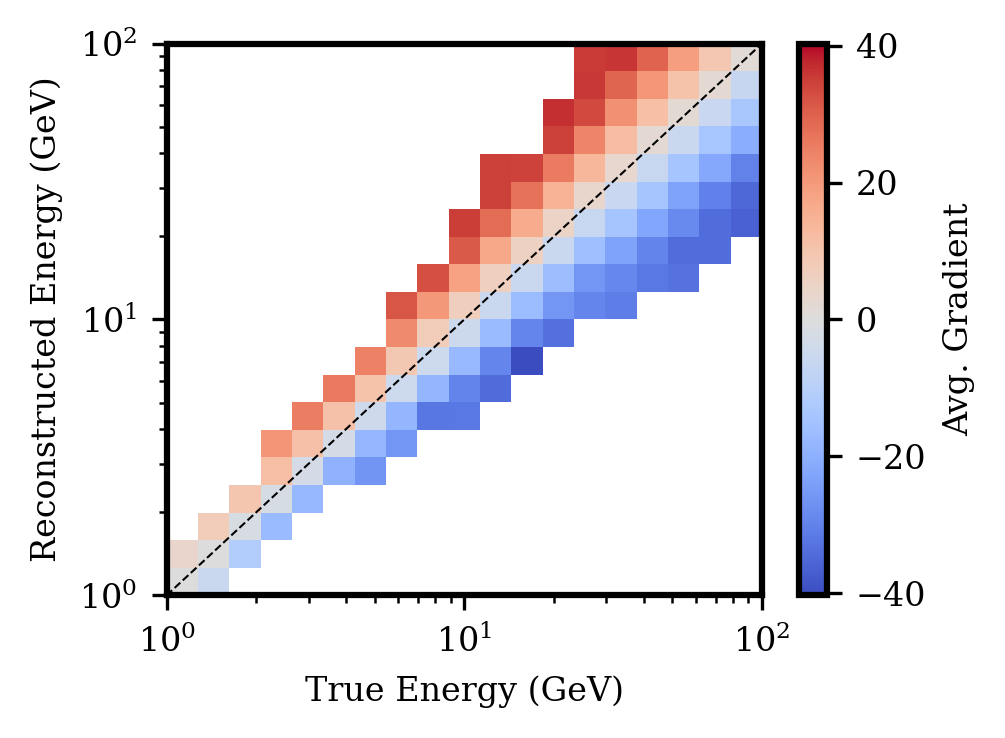

In [18]:
fig, ax = plt.subplots()
im = plot_gradient_map(
    df_with_grads, "grad__mu", np.geomspace(1, 100, 20), np.geomspace(1, 100, 21), ax=ax
)
ax.plot([1, 100], [1, 100], "k--", lw=0.5)
cbar = plt.colorbar(im)
# plt.grid(which="major", axis="both")
cbar.set_label("Avg. Gradient")
plt.tight_layout()
plt.savefig("plot_output/gradient_map.pdf")
plt.show()


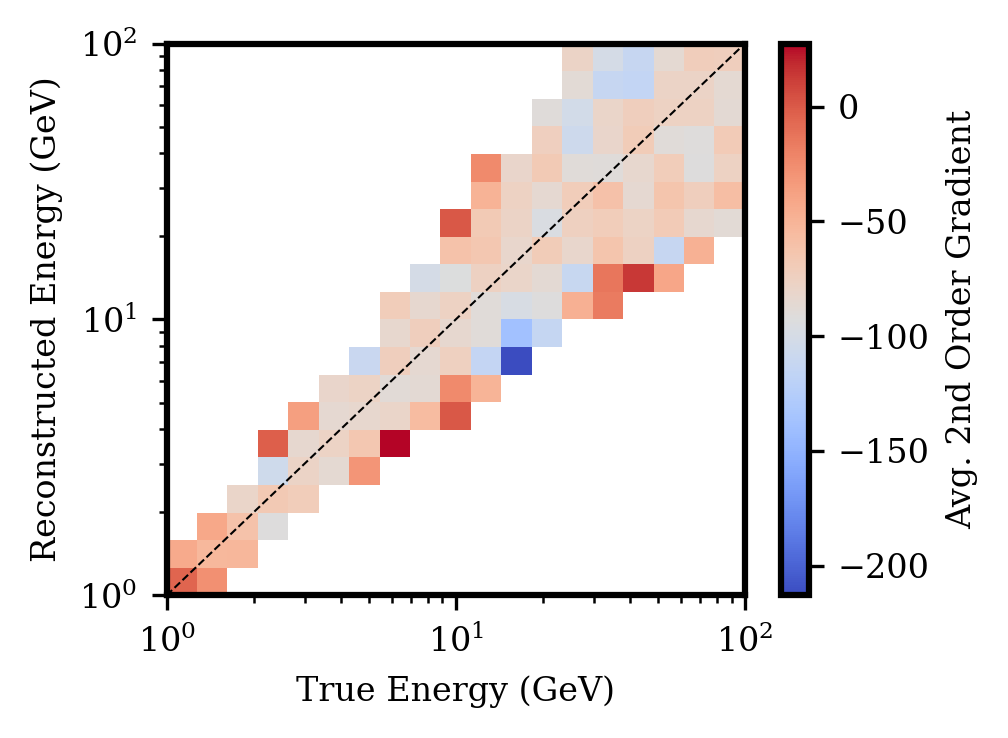

In [19]:
fig, ax = plt.subplots()
im = plot_gradient_map(
    df_with_grads,
    "grad__mu__mu",
    np.geomspace(1, 100, 20),
    np.geomspace(1, 100, 21),
    ax=ax,
    symmetric=False,
)
ax.plot([1, 100], [1, 100], "k--", lw=0.5)
cbar = plt.colorbar(im)
# plt.grid(which="major", axis="both")
cbar.set_label("Avg. 2nd Order Gradient")
plt.tight_layout()
plt.savefig("plot_output/gradient_map_2nd_order.pdf")
plt.show()


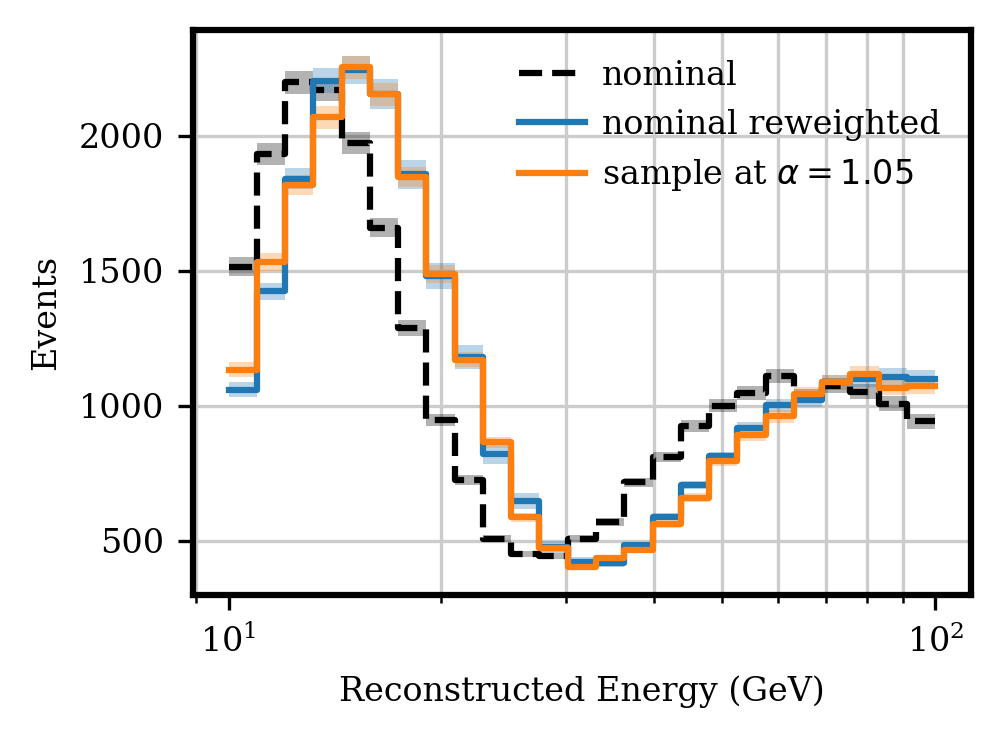

In [20]:
hist_at_sys_01 = generate_histogram_at_response(
    gen_nominal,
    df_with_grads,
    gen_sys_1.detector_response,
    bin_edges
)

gen_sys_1_resampled = generator.Generator(
    int(1.05 * 1e5),
    generator.Response(1.05 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_01",
    rng_seed=42
)
sys_hist = gen_sys_1_resampled.get_histogram(bin_edges)
nominal_hist = gen_nominal.get_histogram(bin_edges)

# plot the histograms
fig, ax = plt.subplots()

plot_histogram(nominal_hist, ax=ax, label="nominal", linestyle="--", color="k")
plot_histogram(hist_at_sys_01, ax=ax, label="nominal reweighted")
plot_histogram(sys_hist, ax=ax, label=r"sample at $\alpha=1.05$")
plt.grid(which="both", axis="x")
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Events")
plt.semilogx()
plt.legend()
plt.tight_layout()
plt.savefig("plot_output/histogram_at_sys_01.pdf")
plt.show()

In [21]:
# sweep response parameter mu around nominal value and plot the histograms
mus = np.linspace(0.95, 1.05, 200)
hists = []
for mu in mus:
    response = generator.Response(mu * default_response.mu, default_response.sigma)
    hists.append(
        generate_histogram_at_response(
            gen_nominal,
            df_with_grads,
            response,
            bin_edges
        )
    )


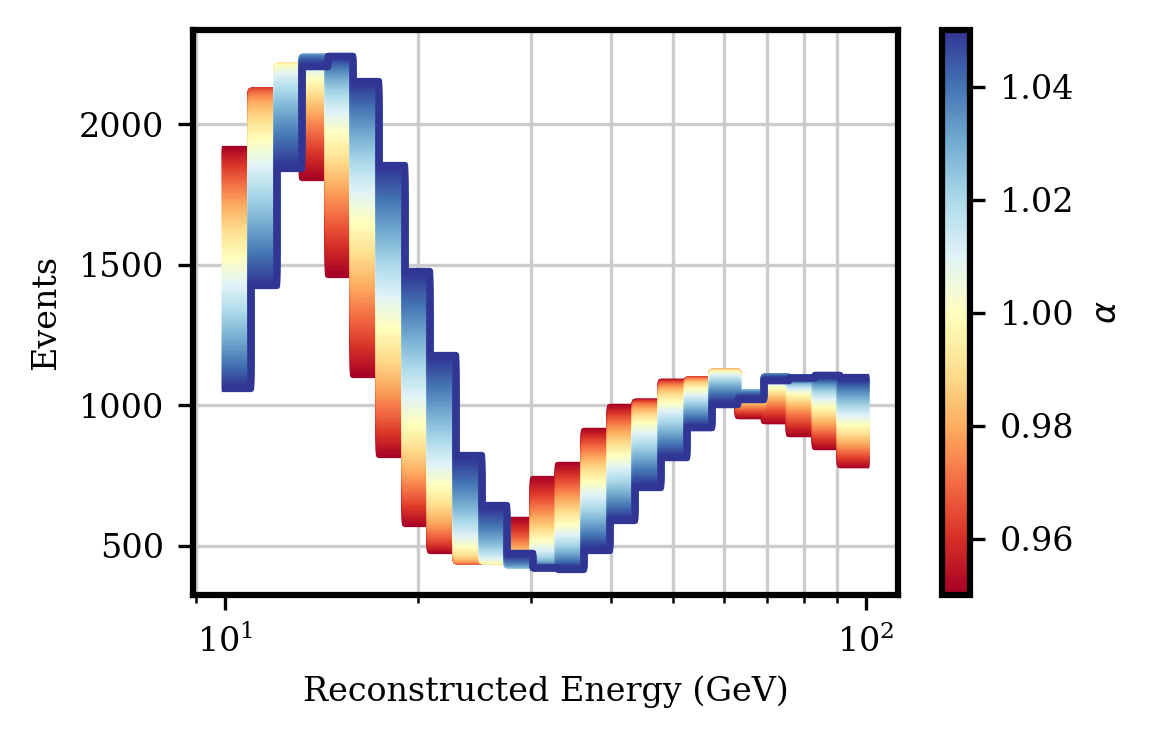

In [22]:
fig, ax = plt.subplots(figsize=(3.875, 2.5))
# make list of colors from a colormap
# colors = plt.cm.viridis(np.linspace(0, 1, len(mus)))
colors = plt.cm.RdYlBu(np.linspace(0, 1, len(mus)))
for hist, mu, color in zip(hists, mus, colors):
    plot_histogram(
        hist,
        ax=ax,
        show_errorband=False,
        label="mu = {}".format(mu),
        color=color,
        rasterized=False,
    )
# make colorbar
sm = plt.cm.ScalarMappable(
    # cmap=plt.cm.viridis,
    cmap=plt.cm.RdYlBu,
    norm=plt.Normalize(vmin=mus.min(), vmax=mus.max())
)
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\alpha$")
plt.grid(which="both", axis="x")
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Events")
plt.semilogx()
plt.tight_layout()
plt.savefig("plot_output/histogram_sweep_mu.pdf")
plt.show()


In [23]:
chi2_knn_grads = []
mu_space = np.linspace(0.9, 1.1, 41)
for mu in mu_space:
    test_response = generator.Response(mu, default_response.sigma)
    chi2_knn_grads.append(
        chi_square_at_response(
            gen_nominal=gen_nominal,
            df=df_with_grads,
            response=test_response,
            bin_edges=bin_edges
        )
    )


[]

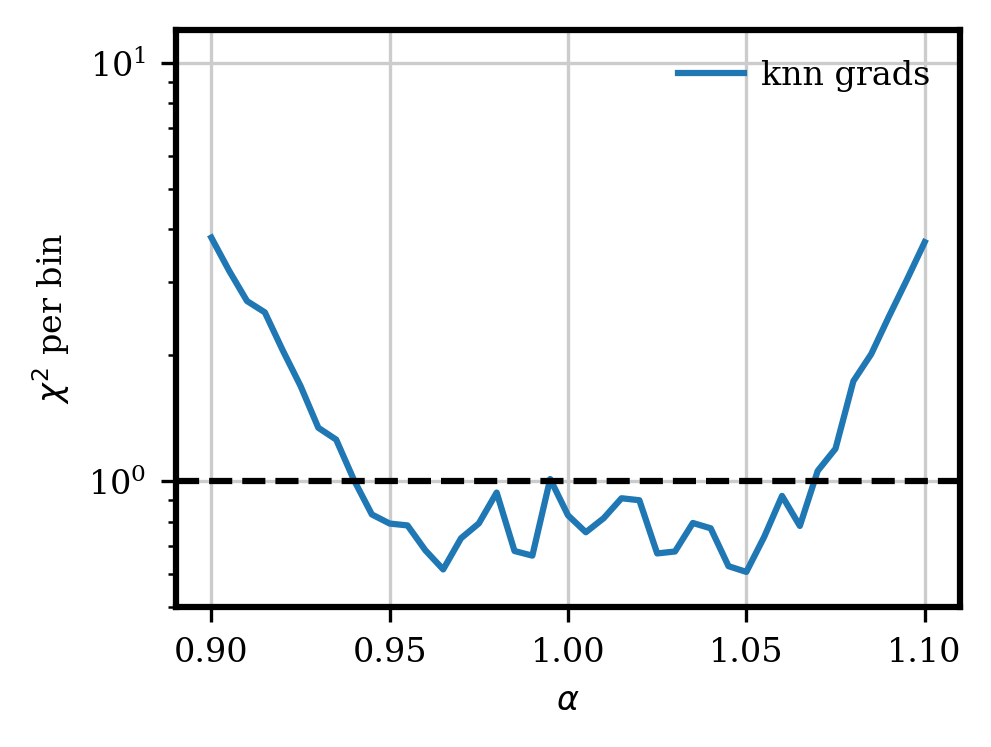

In [24]:
n_bins = len(bin_edges) - 1
plt.plot(mu_space, np.asarray(chi2_knn_grads) / n_bins, label="knn grads")
plt.axhline(1, color="k", linestyle="--")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\chi^2$ per bin")
plt.legend()
plt.ylim(0.5, 12)
plt.semilogy()

### Test different settings of number of neighbors
Repeat the entire process of calculating KNN probabilities and fitting gradients for 
different settings. Then, we make the plot showing chi-square per bin again with
one line for each setting.

import pandas as pd

from typing import List
from toy_mc.generator import Generator


def make_gradients(
    gen_nominal: Generator,
    systematic_generators: List[Generator] = [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables: List[str] = ["true_energy", "reco_energy"],
    tilt_bias_correction: bool = True,
    neighbors_per_class: int = 200,
    systematics: List[str] = ["mu"],
    poly_degree: int = 2,
) -> pd.DataFrame:
    """
    Calculate gradients for a given nominal generator and systematic generators.

    Parameters
    ----------
    gen_nominal : Generator
        The nominal generator.
    systematic_generators : List[Generator], optional
        The list of systematic generators. Defaults to [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4].
    variables : List[str], optional
        The list of variable names to use in the classifier. Defaults to ["true_energy", "reco_energy"].
    tilt_bias_correction : bool, optional
        Whether to perform tilt correction. Defaults to True.
    neighbors_per_class : int, optional
        The number of KNN neighbors per truth class. Defaults to 200.
    systematics : List[str], optional
        The list of systematic types to use in the calculation. Defaults to ["mu"].
    poly_degree : int, optional
        The polynomial degree to fit gradients for. Defaults to 2.

    Returns
    -------
    df_with_grads_output : pd.DataFrame
        A Pandas DataFrame containing the calculated gradients.
    """
    
    # apply KNN
    df_with_probs_tmp = calculate_probs.calculate_probs_sklearn(
        gen_nominal,
        systematic_generators,
        variables=variables,
        tilt_bias_correction=tilt_bias_correction,
        neighbors_per_class=neighbors_per_class,
        jobs=4
    )
    
    # get gradient names for systematic "mu"
    grad_names = calculate_grads.make_gradient_names(systematics, poly_features=poly_degree)
    
    # make delta_p matrix for the systematic "mu" 
    # (i.e. the detector response)
    delta_p = calculate_grads.make_delta_p_from_grad_names(
        grad_names, systematic_generators, gen_nominal
    )
    
    prob_columns = [f"prob_{gen.name}" for gen in [gen_nominal] + systematic_generators]
    
    # Calculate the gradients
    df_with_grads_output = calculate_grads.fit_gradients(
        df_with_probs_tmp, 
        prob_columns=prob_columns, 
        delta_p=delta_p, 
        grad_names=grad_names
    )
    
    return df_with_grads_output


df_with_grads_1000 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=1000,
    systematics=["mu"],
    poly_degree=2,
)

df_with_grads_200 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=200,
    systematics=["mu"],
    poly_degree=2,
)

df_with_grads_100 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=100,
    systematics=["mu"],
    poly_degree=2,
)

df_with_grads_50 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=50,
    systematics=["mu"],
    poly_degree=2,
)

df_with_grads_20 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=20,
    systematics=["mu"],
    poly_degree=2,
)

df_with_grads_10 = make_gradients(
    gen_nominal=gen_nominal,
    systematic_generators=[gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    variables=["true_energy", "reco_energy"],
    tilt_bias_correction=True,
    neighbors_per_class=10,
    systematics=["mu"],
    poly_degree=2,
)


def make_chi2_plot(df, mu_space, bin_edges):
    chi2_knn_grads = []
    for mu in mu_space:
        test_response = generator.Response(mu, default_response.sigma)
        chi2_knn_grads.append(
            chi_square_at_response(
                df, default_response, test_response, bin_edges
            )
        )
    return chi2_knn_grads

chi2_dict = {
    "1000": make_chi2_plot(df_with_grads_1000, mu_space, bin_edges),
    "200": make_chi2_plot(df_with_grads_200, mu_space, bin_edges),
    "100": make_chi2_plot(df_with_grads_100, mu_space, bin_edges),
    "50": make_chi2_plot(df_with_grads_50, mu_space, bin_edges),
    "20": make_chi2_plot(df_with_grads_20, mu_space, bin_edges),
    "10": make_chi2_plot(df_with_grads_10, mu_space, bin_edges),
}

# use a colormap to plot the different number of neighbors
cmap = plt.get_cmap("winter_r")
# cmap = plt.get_cmap("autumn_r")
min_neighbors = np.min([int(n) for n in chi2_dict.keys()]) * 5
max_neighbors = np.max([int(n) for n in chi2_dict.keys()]) * 5 

for n_neighbors in chi2_dict:
    chi2_list = np.asarray(chi2_dict[n_neighbors]) / n_bins
    # compute total number of neighbors, which is n_neighbors * n_classes,
    # where n_classes is 5 for the 4 systematic generators and the nominal
    tot_neighbors = int(n_neighbors) * 5
    color_frac = (np.log10(tot_neighbors) - np.log10(min_neighbors)) / (
        np.log10(max_neighbors) - np.log10(min_neighbors)
    )
    plt.plot(
        mu_space,
        chi2_list,
        label=f"{tot_neighbors} neighbors",
        color=cmap(color_frac),
    )
plt.axhline(1, color="k", linestyle="--")
plt.legend()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\chi^2$ per bin")
plt.semilogy()
plt.tight_layout()
plt.savefig("plot_output/chi2_vs_neighbors.pdf")
plt.show()


## Compare to old method of bin-wise linear regressions


import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ultrasurfaces_paper_plotstyle.mplstyle")

from toy_mc import generator
from importlib import reload

delta_msq_31 = 2.515e-3
sinsq_theta_23 = 0.565
# convert this to sin**2(2 \theta)
theta_23 = np.arcsin(np.sqrt(sinsq_theta_23))
sinsq_2theta_23 = np.sin(2 * theta_23)**2
default_pars = generator.OscPars(delta_msq_31, sinsq_2theta_23)

default_response = generator.Response(1., 0.08)

bin_edges = np.logspace(1., 2., 26)

In [25]:
gen = generator.Generator(int(1e5), default_response, default_pars)
h0 = gen.get_histogram(bin_edges)
h0_true = gen.get_histogram(bin_edges, variable="true_energy")

# Generate several sets at different values of mu
reload(generator)
gen_nominal = generator.Generator(
    int(1e5), default_response, default_pars, name="nominal", rng_seed=0
)
# It looks like there is a breakdown point where, if the response is *too* different,
# the whole thing doesn't work anymore.
gen_sys_1 = generator.Generator(
    int(1.05 * 1e5),
    generator.Response(1.05 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_01",
    rng_seed=0
)
gen_sys_2 = generator.Generator(
    int(0.95 * 1e5),
    generator.Response(0.95 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_02",
    rng_seed=0
)
gen_sys_3 = generator.Generator(
    int(0.975 * 1e5),
    generator.Response(0.975 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_03",
    rng_seed=0
)
gen_sys_4 = generator.Generator(
    int(1.025 * 1e5),
    generator.Response(1.025 * default_response.mu, default_response.sigma),
    default_pars,
    name="sys_04",
    rng_seed=0
)

In [26]:
from utils import get_binwise_gradients, get_histogram_at_response_gradient_method

In [27]:
get_binwise_gradients(gen, [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4], "mu", "reco_energy", bin_edges, degree=2)

array([[-11.69138544,  -5.7128815 ,   1.00184904],
       [-32.57844698,  -3.5618802 ,   0.98771256],
       [-50.72842589,  -0.64420946,   1.01897749],
       [-25.05676869,   1.58171733,   0.98413148],
       [-22.85696854,   3.85309788,   1.00271636],
       [ -5.44456697,   6.29916143,   0.99297667],
       [ 29.42681869,   8.36634701,   0.99622662],
       [ 48.48733304,   9.95738668,   1.03360233],
       [ 64.64709074,   9.69333057,   1.02343303],
       [ 81.92453461,   6.92159112,   0.97448576],
       [124.04091039,   2.53508721,   0.97380111],
       [ 79.84448243,  -3.18130829,   0.98721243],
       [ 76.27770768,  -6.80252774,   1.02046427],
       [ 31.60799638,  -7.12495847,   1.03021535],
       [ -1.44476843,  -6.33803394,   1.00354899],
       [ -6.42682987,  -4.84064838,   0.9835804 ],
       [-19.94150564,  -3.68154075,   1.01921567],
       [-10.65179921,  -2.86985028,   0.97963588],
       [-20.07583572,  -1.26441399,   1.00296956],
       [-23.17343364,  -0.69736

In [28]:
from typing import Tuple
from typing import List

def plot_fit_in_bin(
    nominal_dataset: generator.Generator,
    binwise_gradients: np.ndarray,
    sys_variable: str,
    range: Tuple[float, float],
    bin_idx: int,
    bin_edges: np.ndarray,
    bin_variable: str,
    ax: plt.Axes,
    include_intecpt: bool = True,
    **plot_kwargs,
):
    """Plot the fit in a given bin.

    Parameters
    ----------
    binwise_gradients : np.ndarray
        The bin-wise gradients and intercept values.
    sys_variable : str
        The systematic variable to use for the interpolation. This has to be one of the attributes of the detector response.
    range : Tuple[float, float]
        The range of the systematic variable to plot.
    bin_idx : int
        The bin index to plot.
    bin_edges : np.ndarray
        The bin edges for bin_variable.
    bin_variable : str
        The variable to bin in.
    ax : plt.Axes
        The axes to plot on.
    include_intecpt : bool, optional
        Whether to include the intercept in the linear regression, by default True.
    **plot_kwargs
        Keyword arguments passed to ax.plot.
    """

    assert hasattr(nominal_dataset.detector_response, sys_variable), (
        f"sys_variable '{sys_variable}' not in response attributes."
    )
    nominal_value = nominal_dataset.get_histogram(bin_edges, variable=bin_variable).hist[bin_idx]
    gradients = binwise_gradients[bin_idx]
    # plot fit over a slightly larger range than the data
    nominal_sys_value = getattr(nominal_dataset.detector_response, sys_variable)
    sys_values_fit = np.linspace(range[0], range[1], 100) - nominal_sys_value
    ax.plot(
        sys_values_fit,
        np.polyval(gradients, sys_values_fit) * nominal_value,
        **plot_kwargs,
    )
    return ax

def plot_data_in_bin(
    nominal_dataset: generator.Generator,
    sys_datasets: List[generator.Generator],
    sys_variable: str,
    bin_idx: int,
    bin_edges: np.ndarray,
    bin_variable: str,
    ax: plt.Axes,
    include_intecpt: bool = True,
    osc_pars: generator.OscPars = default_pars,
    divide_nominal: bool = True,
    **plot_kwargs,
):
    """Plot the data in a given bin.

    Parameters
    ----------
    nominal_dataset : generator.Generator
        The nominal dataset.
    sys_datasets : List[generator.Generator]
        The systematic datasets.
    sys_variable : str
        The systematic variable to use for the interpolation. This has to be one of the attributes of the detector response.
    bin_idx : int
        The bin index to plot.
    bin_edges : np.ndarray
        The bin edges for bin_variable.
    bin_variable : str
        The variable to bin in.
    ax : plt.Axes
        The axes to plot on.
    include_intecpt : bool, optional
        Whether to include the intercept in the linear regression, by default True.
    osc_pars : generator.OscPars, optional
        The oscillation parameters to use to weight the events.
    divide_nominal : bool, optional
        Whether to divide the data by the nominal value, by default True.
    **plot_kwargs
        Keyword arguments passed to ax.plot.
    """
    assert hasattr(nominal_dataset.detector_response, sys_variable), (
        f"sys_variable '{sys_variable}' not in response attributes."
    )
    nominal_dataset.reweight_oscillation(osc_pars)
    nominal_hist = nominal_dataset.get_histogram(bin_edges, variable=bin_variable)
    for sys_dataset in sys_datasets:
        sys_dataset.reweight_oscillation(osc_pars)
    sys_hists = [
        sys_dataset.get_histogram(bin_edges, variable=bin_variable)
        for sys_dataset in sys_datasets
    ]
    all_hists = [nominal_hist] + sys_hists
    nominal_sys_value = getattr(nominal_dataset.detector_response, sys_variable)
    sys_values = [getattr(sys_dataset.detector_response, sys_variable) - nominal_sys_value for sys_dataset in sys_datasets]
    sys_values = [0.0] + sys_values

    # reset all oscillation weights
    nominal_dataset.reweight_oscillation(default_pars)
    for sys_dataset in sys_datasets:
        sys_dataset.reweight_oscillation(default_pars)
    nominal_value = nominal_hist.hist[bin_idx]
    bin_values = np.asarray([hist.hist[bin_idx] for hist in all_hists])
    bin_uncertainties = np.asarray([hist.hist_unc[bin_idx] for hist in all_hists])
    if divide_nominal:
        bin_values /= nominal_value
        bin_uncertainties /= nominal_value
    # plot
    (_, caps, _) = ax.errorbar(
        sys_values,
        bin_values,
        yerr=bin_uncertainties,
        **plot_kwargs,
    )
    # for some reason, we need to set the color of caps manually because they are always black
    if "color" in plot_kwargs:
        for cap in caps:
            cap.set_color(plot_kwargs["color"])
    return ax


In [29]:
from copy import copy
from typing import Any, Optional
import pandas as pd

def plot_prediction_in_bin(
    df: pd.DataFrame,
    gen_nominal: generator.Generator,
    sys_variable: str,
    plot_range: Tuple[float, float],
    bin_edges: np.ndarray,
    bin_idx: int,
    bin_variable: str = "reco_energy",
    ax: Optional[plt.Axes] = None,
    **plot_kwargs: Any,
) -> plt.Axes:
    """Plot the prediction in a given bin using the event-wise gradients.
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing the nominal MC set with event-wise gradients.
    gen_nominal : generator.Generator
        The nominal MC set generator.
    sys_variable : str
        The systematic variable to use for the interpolation. The corresponding gradient columns have to exist in the DataFrame
        and the response.
    plot_range : Tuple[float, float]
        The range of the systematic variable to plot.
    bin_edges : np.ndarray
        The bin edges of the bin_variable.
    bin_idx : int
        The bin index to plot.
    bin_variable : str, optional
        The variable to bin in, by default "reco_energy"
    **plot_kwargs
        Keyword arguments passed to plt.plot.
    """

    plot_points = 100
    plot_x = np.linspace(plot_range[0], plot_range[1], plot_points)
    predictions = []
    # For every point we want to plot, we create the corresponding response and then 
    # generate the histogram at that response.
    nominal_response = gen_nominal.detector_response
    for x in plot_x:
        # make a new modified response
        # Note that the response is a subclass of NamedTuple, so we can use the _replace method
        modified_response = nominal_response._replace(**{sys_variable: x})
        this_point_hist = generate_histogram_at_response(gen_nominal, df, modified_response, bin_edges, use_systs=None, variable=bin_variable)
        predictions.append(this_point_hist.hist[bin_idx])
    if ax is None:
        ax = plot_kwargs.pop("ax", plt.gca())
    nominal_sys_value = getattr(nominal_response, sys_variable)
    ax.plot(plot_x - nominal_sys_value, predictions, **plot_kwargs)
    return ax

Text(0.05, 0.05, '36.3 GeV < $E_\\mathrm{reco}$ < 39.8 GeV')

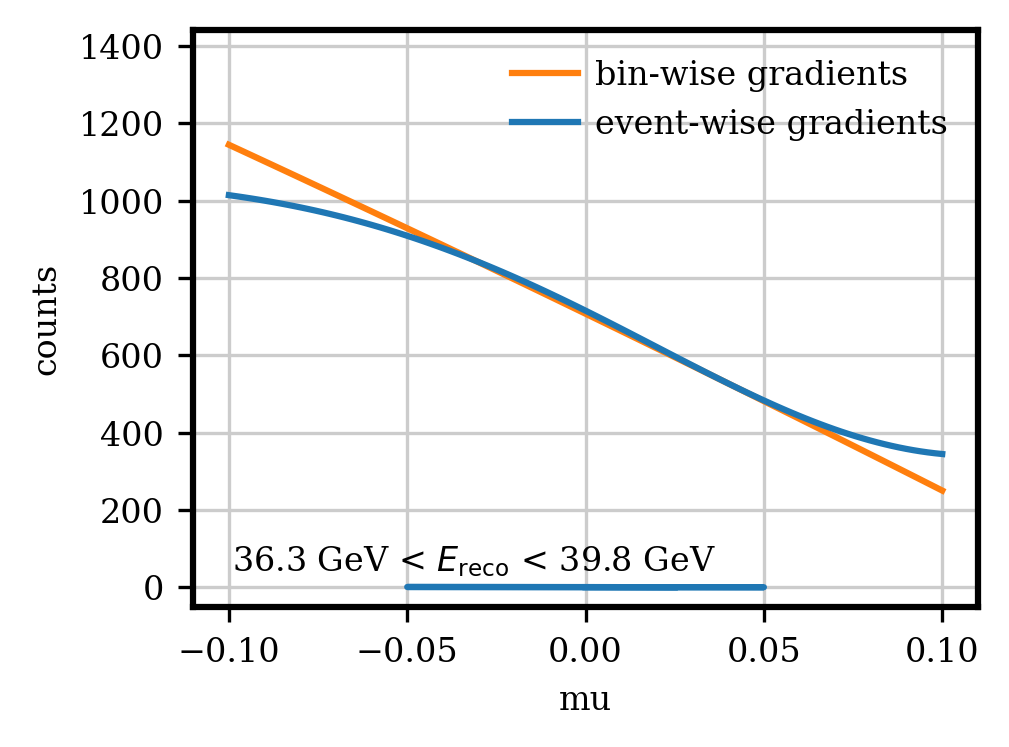

In [30]:
bin_idx = 14
binwise_gradients = get_binwise_gradients(gen, [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4], "mu", "reco_energy", bin_edges, degree=2)
sys_values = [g.detector_response.mu for g in [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4]]
# plot in a range that extends a bit beyond the data
plot_range = (np.min(sys_values) - 0.05, np.max(sys_values) + 0.05)
fig, ax = plt.subplots()
ax = plot_data_in_bin(
    gen,
    [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    "mu",
    bin_idx,
    bin_edges,
    "reco_energy",
    ax,
)
ax = plot_fit_in_bin(
    gen,
    binwise_gradients,
    "mu",
    plot_range,
    bin_idx,
    bin_edges,
    "reco_energy",
    ax,
    label="bin-wise gradients"
)
ax = plot_prediction_in_bin(
    df_with_grads,
    gen_nominal,
    "mu",
    plot_range,
    bin_edges,
    bin_idx,
    "reco_energy",
    ax,
    label="event-wise gradients",
    color="C0",
)
ax.legend(loc="upper right")
ax.set_xlabel("mu")
ax.set_ylabel("counts")
# Expand the plot limits in the y direction so that the legend and the bottom description
# don't overlap with the plot
ax.set_ylim(ax.get_ylim()[0] * 0.9, ax.get_ylim()[1] * 1.2)


# Add description of the bin that is being plotted
bin_description = rf"{bin_edges[bin_idx]:.1f} GeV < $E_\mathrm{{reco}}$ < {bin_edges[bin_idx + 1]:.1f} GeV"
ax.text(
    0.05,
    0.05,
    bin_description,
    horizontalalignment="left",
    verticalalignment="bottom",
    transform=ax.transAxes,
)

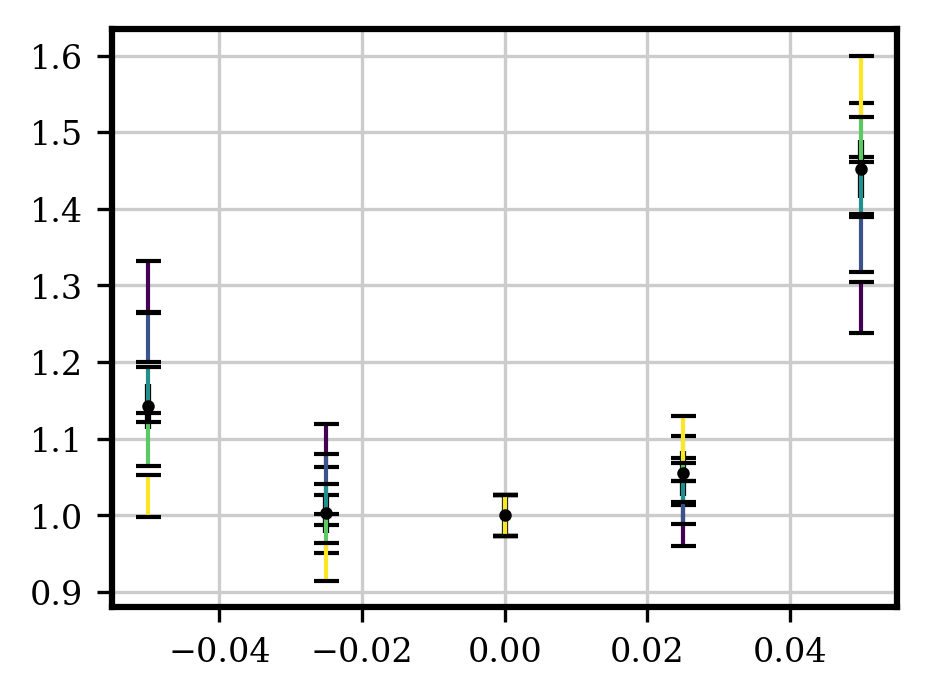

In [31]:
# The bin counts are going to change as a function of the assumed mass splitting that we use to 
# weight the events. 

delta_msq_31_plot = 2.515e-3

modified_osc_pars = default_pars._replace(delta_mqs=delta_msq_31_plot)

bin_idx = 10
binwise_gradients = get_binwise_gradients(gen, [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4], "mu", "reco_energy", bin_edges, degree=2)
sys_values = [g.detector_response.mu for g in [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4]]
# plot in a range that extends a bit beyond the data
plot_range = (np.min(sys_values) - 0.05, np.max(sys_values) + 0.05)
fig, ax = plt.subplots()
ax = plot_data_in_bin(
    gen,
    [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    "mu",
    bin_idx,
    bin_edges,
    "reco_energy",
    ax,
    osc_pars=modified_osc_pars,
    color="k",
    fmt="o",
    label="default oscillation parameters"
)

plot_delta_msq_31 = np.linspace(2.4e-3, 2.6e-3, 5)
for delta_msq_31 in plot_delta_msq_31:
    modified_osc_pars = default_pars._replace(delta_mqs=delta_msq_31)
    color = plt.cm.viridis((delta_msq_31 - np.min(plot_delta_msq_31)) / (np.max(plot_delta_msq_31) - np.min(plot_delta_msq_31)))
    ax = plot_data_in_bin(
        gen,
        [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
        "mu",
        bin_idx,
        bin_edges,
        "reco_energy",
        ax,
        osc_pars=modified_osc_pars,
        label=rf"$\Delta m^2_{{31}} = {delta_msq_31:.3e}$",
        color=color,
        ls="",capsize=3, lw=1,
    )

In [32]:
# sweep response parameter mu around nominal value and plot the histograms
binwise_gradients = get_binwise_gradients(gen, [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4], "mu", "reco_energy", bin_edges, degree=2)
mus = np.linspace(0.95, 1.05, 200)
hists = []
for mu in mus:
    response = generator.Response(mu * default_response.mu, default_response.sigma)
    hists.append(
        get_histogram_at_response_gradient_method(
            gen, binwise_gradients, "mu", "reco_energy", bin_edges, response
        )
    )

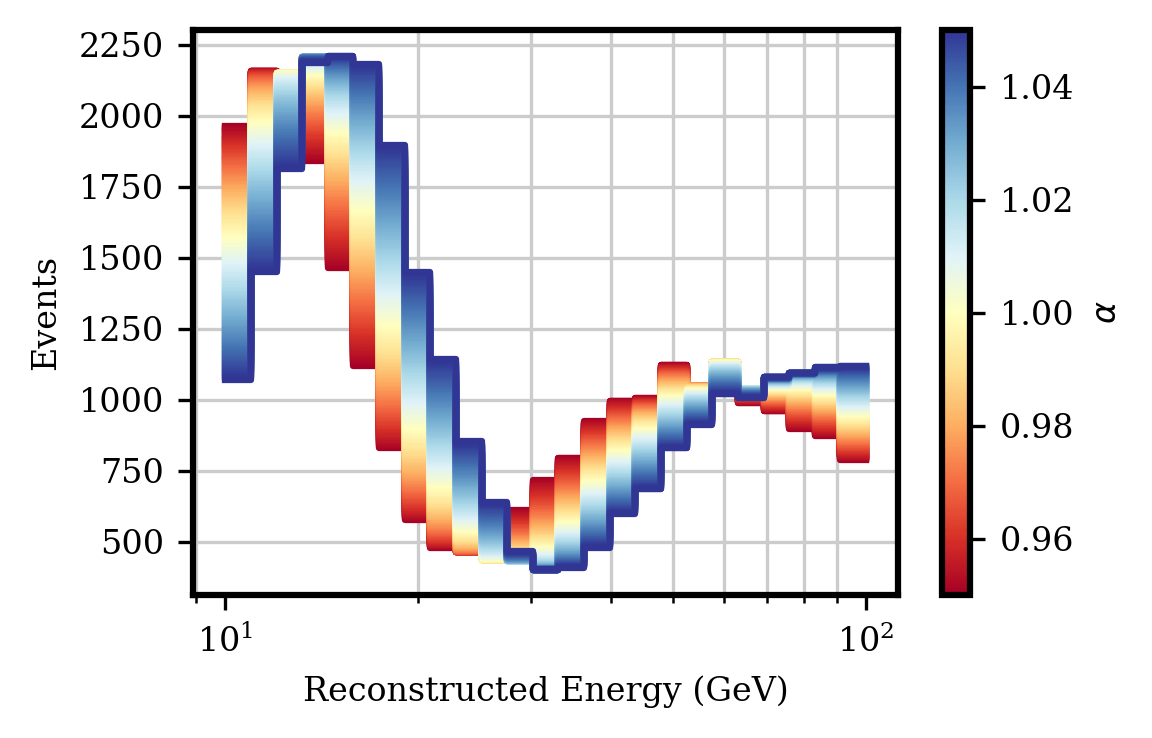

In [33]:
fig, ax = plt.subplots(figsize=(3.875, 2.5))
# make list of colors from a colormap
# colors = plt.cm.viridis(np.linspace(0, 1, len(mus)))
colors = plt.cm.RdYlBu(np.linspace(0, 1, len(mus)))
for hist, mu, color in zip(hists, mus, colors):
    plot_histogram(
        hist,
        ax=ax,
        show_errorband=False,
        label="mu = {}".format(mu),
        color=color,
        rasterized=False,
    )
# make colorbar
sm = plt.cm.ScalarMappable(
    # cmap=plt.cm.viridis,
    cmap=plt.cm.RdYlBu,
    norm=plt.Normalize(vmin=mus.min(), vmax=mus.max())
)
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\alpha$")
plt.grid(which="both", axis="x")
plt.xlabel("Reconstructed Energy (GeV)")
plt.ylabel("Events")
plt.semilogx()
plt.tight_layout()
plt.savefig("plot_output/histogram_sweep_mu_gradient_method_poly_2.pdf")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.05, 0.05, '14.5 GeV < $E_\\mathrm{reco}$ < 15.8 GeV')

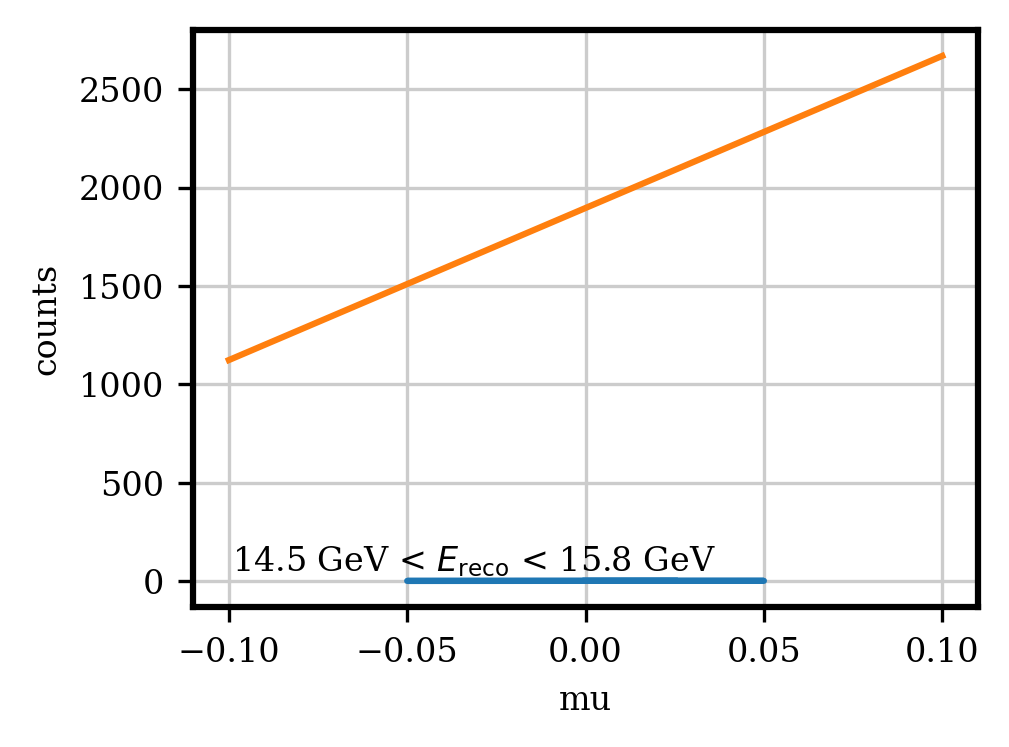

In [34]:
bin_idx = 4
binwise_gradients = get_binwise_gradients(gen, [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4], "mu", "reco_energy", bin_edges)
sys_values = [g.detector_response.mu for g in [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4]]
# plot in a range that extends a bit beyond the data
plot_range = (np.min(sys_values) - 0.05, np.max(sys_values) + 0.05)
fig, ax = plt.subplots()
ax = plot_data_in_bin(
    gen,
    [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    "mu",
    bin_idx,
    bin_edges,
    "reco_energy",
    ax,
)
ax = plot_fit_in_bin(
    gen,
    binwise_gradients,
    "mu",
    plot_range,
    bin_idx,
    bin_edges,
    "reco_energy",
    ax,
)
ax.legend(loc="upper right")
ax.set_xlabel("mu")
ax.set_ylabel("counts")

# Add description of the bin that is being plotted
bin_description = rf"{bin_edges[bin_idx]:.1f} GeV < $E_\mathrm{{reco}}$ < {bin_edges[bin_idx + 1]:.1f} GeV"
ax.text(
    0.05,
    0.05,
    bin_description,
    horizontalalignment="left",
    verticalalignment="bottom",
    transform=ax.transAxes,
)

# Make chi2 comparison for both methods at different predicted mass splittings

In [35]:
from utils import chi_square_at_response_and_osc_eventwise
from utils import chi_square_at_response_and_osc_binwise

In [36]:
def plot_chi2_comparison_mass_splittings(
    nominal_dataset: generator.Generator,
    binwise_gradients: np.ndarray,
    df : pd.DataFrame,
    bin_edges: np.ndarray,
    bin_variable: str = "reco_energy",
    sys_variable: str = "mu",
    osc_pars_test: List[generator.OscPars] = [default_pars],
    # divide_nominal: bool = True,
):

    n_bins = len(bin_edges) - 1

    mus_range = (0.95, 1.05)
    mus = np.linspace(mus_range[0], mus_range[1], 10)

    fig, ax = plt.subplots()

    # second legend: linestyles
    ax.plot([], [], color="k", ls="-.", label="eventwise")
    ax.plot([], [], color="k", ls=":", label="binwise")
    # l2 = ax.legend(loc='lower right')

    for i, osc_pars in enumerate(osc_pars_test):

        # get different chi^2
        chi2_evtwise = []
        chi2_binwise = []
        for mu in mus:
            response = generator.Response(mu * default_response.mu, default_response.sigma)

            chi2_evtwise.append(
                    chi_square_at_response_and_osc_eventwise(
                    gen_nominal,
                    df,
                    response,
                    osc_pars,
                    bin_edges,
                    variable=bin_variable,
                )
            )

            chi2_binwise.append(
                    chi_square_at_response_and_osc_binwise(
                    nominal_dataset=nominal_dataset,
                    binwise_gradients=binwise_gradients,
                    sys_variable=sys_variable,
                    bin_variable=bin_variable,
                    bin_edges=bin_edges,
                    response=response,
                    osc_pars=osc_pars
                )
            )

        ax.plot(
            mus, np.asarray(chi2_evtwise) / n_bins,
            color=f"C{i}", linestyle='-.',
            label=r"$\Delta m^2$=" + f"{osc_pars.delta_mqs:.2e}" + r" $\mathrm{eV}^2$",
            alpha=0.75,
        )
        ax.plot(
            mus, np.asarray(chi2_binwise) / n_bins,
            color=f"C{i}", linestyle=':'
        )
    
    ax.set_xlabel(r"$\alpha$")
    # ax.set_xlim(plot_range)
    ax.set_ylabel(r"$\chi^2$ per bin")

    ax.legend()

    # l1 will remove l2, therefore we need to add it back to the artist
    # ax.add_artist(l2)

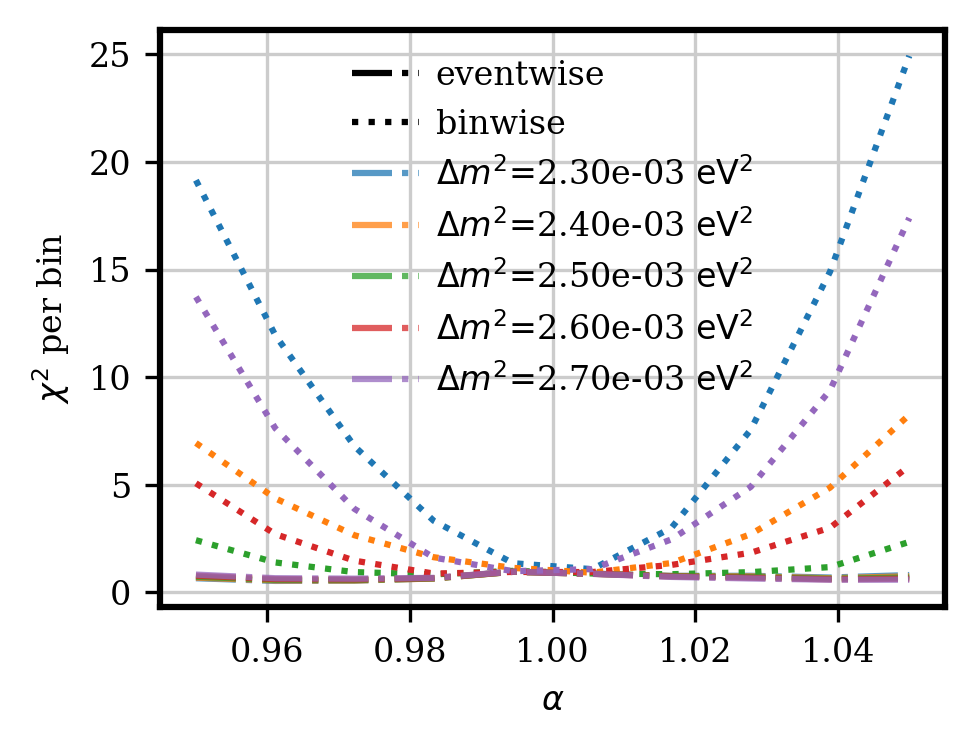

In [38]:
binwise_gradients = get_binwise_gradients(
    gen, [gen_sys_1, gen_sys_2, gen_sys_3, gen_sys_4],
    "mu",
    "reco_energy",
    bin_edges,
    degree=2
)

plot_delta_msq_31 = np.linspace(2.3e-3, 2.7e-3, 5)
osc_pars_test = []
for delta_msq_31 in plot_delta_msq_31:
    osc_pars_test.append(
        generator.OscPars(delta_msq_31, default_pars.sinsq_2theta)
    )

plot_chi2_comparison_mass_splittings(
    nominal_dataset=gen_nominal,
    binwise_gradients=binwise_gradients,
    df=df_with_grads,
    bin_edges=bin_edges,
    osc_pars_test=osc_pars_test
)